In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from ultralytics import YOLO

import tensorflow as tf

In [4]:
TRAIN_DATASET_PATH = "./dataset/train/"
# VAL_DATASET_PATH = "./valid/"
# TEST_DATASET_PATH = "./test/"

In [5]:
path = TRAIN_DATASET_PATH + "labels"

dct = {
    "images": [],
    "labels": [],
    "x_center": [],
    "y_center": [],
    "width": [],
    "height": []
}

for image in os.listdir(path):
    label_file = open(path + "/" + image)

    labels_str = label_file.read().split(sep="\n")
    labels_arr = []
    xmin_arr = []
    ymin_arr = []
    xmax_arr = []
    ymax_arr = []
    for label in labels_str:
        label_parts = label.split()
        labels_arr.append(int(label_parts[0]))
        xmin_arr.append(float(label_parts[1]))
        ymin_arr.append(float(label_parts[2]))
        xmax_arr.append(float(label_parts[3]))
        ymax_arr.append(float(label_parts[4]))

    dct["images"].append(image)
    dct["labels"].append(labels_arr)
    dct["x_center"].append(xmin_arr)
    dct["y_center"].append(ymin_arr)
    dct["width"].append(xmax_arr)
    dct["height"].append(ymax_arr)

    label_file.close()

df = pd.DataFrame(dct)
df

,images,labels,x_center,y_center,width,height
0,009000_jpg.rf.8c46e1aa5b46a0ad24ee4bcb2945d22a...,[2],[0.6538461538461539],[0.5420673076923077],[0.0625],[0.06610576923076923]
1,009002_jpg.rf.18bf80f2cfdb51f853da15019f787cef...,[2],[0.5576923076923077],[0.3389423076923077],[0.055288461538461536],[0.07091346153846154]
2,009003_jpg.rf.46963402c4cb6f46a47e508b892c6521...,[2],[0.4230769230769231],[0.3798076923076923],[0.09975961538461539],[0.055288461538461536]
3,009007_jpg.rf.a5143afbb0c741f3b60fc72403fdde6a...,[2],[0.4014423076923077],[0.35096153846153844],[0.055288461538461536],[0.1778846153846154]
4,009012_jpg.rf.bc99877ade8754d2be89119361e7820c...,[2],[0.8040865384615384],[0.3870192307692308],[0.052884615384615384],[0.07211538461538461]
...,...,...,...,...,...,...
6176,042973_jpg.rf.6792837ba2183435721cd7b4e9674ecd...,[1],[0.3485576923076923],[0.3016826923076923],[0.08533653846153846],[0.08653846153846154]
6177,042982_jpg.rf.79a8b11af76f74faa44312da78ee1486...,[4],[0.3629807692307692],[0.5276442307692307],[0.0625],[0.16706730769230768]
6178,042984_jpg.rf.5005cade401420afa36aac4b818e8dfa...,[1],[0.3870192307692308],[0.36778846153846156],[0.04447115384615385],[0.052884615384615384]
6179,042994_jpg.rf.141176d36edf4a11d33dad95a76e61b6...,[1],[0.5084134615384616],[0.5492788461538461],[0.0889423076923077],[0.06370192307692307]


In [6]:
df[df["labels"].isin([[1]])][:50]

,images,labels,x_center,y_center,width,height
227,009696_jpg.rf.cce06a15455bdfb3ec994de61207f9ec...,[1],[0.7295673076923077],[0.49399038461538464],[0.13822115384615385],[0.0829326923076923]
1272,020535_jpg.rf.1d1f389c1ac9223533b07f19d45d0fed...,[1],[0.5276442307692307],[0.3401442307692308],[0.09254807692307693],[0.12740384615384615]
1986,026032_jpg.rf.7e9a535ddcf0a5013b8c37dffd3739af...,[1],[0.5204326923076923],[0.5072115384615384],[0.06490384615384616],[0.06971153846153846]
1990,026040_jpg.rf.308b8bcf0f012196737af0715b064cbb...,[1],[0.6442307692307693],[0.49399038461538464],[0.06490384615384616],[0.11658653846153846]
1991,026043_jpg.rf.4e6258a0c6557491c1a7619d51f48834...,[1],[0.3245192307692308],[0.5552884615384616],[0.03245192307692308],[0.14783653846153846]
1993,026057_jpg.rf.97d02180613f5ffe322d1cbf89d34031...,[1],[0.5829326923076923],[0.3894230769230769],[0.11177884615384616],[0.07211538461538461]
1994,026074_jpg.rf.7d4a4263d7461b4688a8548deb37ac09...,[1],[0.6129807692307693],[0.5180288461538461],[0.07692307692307693],[0.11899038461538461]
2000,026107_jpg.rf.24622a90c94e31cb97327d1b711882b2...,[1],[0.46033653846153844],[0.5096153846153846],[0.02403846153846154],[0.14543269230769232]
2003,026127_jpg.rf.ddfedfe6d2728271fefebe522bbfaca0...,[1],[0.59375],[0.3293269230769231],[0.06009615384615385],[0.052884615384615384]
2007,026135_jpg.rf.1b7417b83015da5e83efcfb417a00623...,[1],[0.6382211538461539],[0.5120192307692307],[0.06850961538461539],[0.125]


In [7]:
images_path_df = pd.DataFrame({
    "images": os.listdir(TRAIN_DATASET_PATH + "images")
})

images_path_df

,images
0,009000_jpg.rf.8c46e1aa5b46a0ad24ee4bcb2945d22a...
1,009002_jpg.rf.18bf80f2cfdb51f853da15019f787cef...
2,009003_jpg.rf.46963402c4cb6f46a47e508b892c6521...
3,009007_jpg.rf.a5143afbb0c741f3b60fc72403fdde6a...
4,009012_jpg.rf.bc99877ade8754d2be89119361e7820c...
...,...
6176,042973_jpg.rf.6792837ba2183435721cd7b4e9674ecd...
6177,042982_jpg.rf.79a8b11af76f74faa44312da78ee1486...
6178,042984_jpg.rf.5005cade401420afa36aac4b818e8dfa...
6179,042994_jpg.rf.141176d36edf4a11d33dad95a76e61b6...


In [ ]:
fig, ax = plt.subplots(1)
index = 2110

x_start = df["x_center"][index][0] - df["width"][index][0] / 2
y_start = df["y_center"][index][0] - df["height"][index][0] / 2

rect = patches.Rectangle((x_start * 416, y_start * 416), df["width"][index][0] * 416, df["height"][index][0] * 416, edgecolor="red", facecolor="none")

ax.add_patch(rect)
ax.imshow(Image.open(TRAIN_DATASET_PATH + "images/" + images_path_df["images"][index]))
print(df["labels"][index][0])

plt.show()

: 

In [8]:
plt.plot(df["x_center"][1993][0] * 416, df["y_center"][1993][0] * 416, marker='o', markersize=2, color="red")
plt.imshow(Image.open(TRAIN_DATASET_PATH + "images/" + images_path_df["images"][1993]))
print(df["labels"][1993][0])

1


: 

In [1]:
import os

label_dir = './train/labels/'
class_counts = {}

for file in os.listdir(label_dir):
    with open(os.path.join(label_dir, file), 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) > 0:
                class_id = int(parts[0])
                class_counts[class_id] = class_counts.get(class_id, 0) + 1

print(class_counts)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './train/labels/'

In [25]:
import os

label_dir = './test/labels/'
class_counts = {}

for file in os.listdir(label_dir):
    with open(os.path.join(label_dir, file), 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) > 0:
                class_id = int(parts[0])
                class_counts[class_id] = class_counts.get(class_id, 0) + 1

print(class_counts)

{2: 118, 1: 193, 0: 166, 3: 203, 4: 203}


In [26]:
import os

label_dir = './valid/labels/'
class_counts = {}

for file in os.listdir(label_dir):
    with open(os.path.join(label_dir, file), 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) > 0:
                class_id = int(parts[0])
                class_counts[class_id] = class_counts.get(class_id, 0) + 1

print(class_counts)

{2: 225, 0: 391, 3: 366, 1: 389, 4: 395}


In [40]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')
model.train(data='data.yaml', epochs=30, imgsz=416, batch=16)

100%|██████████| 6.25M/6.25M [00:01<00:00, 6.24MB/s]


New https://pypi.org/project/ultralytics/8.3.137 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.136  Python-3.9.21 torch-2.7.0+cpu CPU (AMD Ryzen 5 5600 6-Core Processor)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=

100%|██████████| 755k/755k [00:00<00:00, 5.07MB/s]

Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192, 64, 1]                  
 16                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning C:\Users\Zaky\Documents\p2-final-project-ftds-hck-026\train\labels... 6181 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6181/6181 [00:04<00:00, 1456.50it/s]


train: New cache created: C:\Users\Zaky\Documents\p2-final-project-ftds-hck-026\train\labels.cache
val: Fast image access  (ping: 0.30.1 ms, read: 3.70.9 MB/s, size: 19.3 KB)


c:\Users\Zaky\anaconda3\envs\tensorflow\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\Zaky\Documents\p2-final-project-ftds-hck-026\valid\labels... 1766 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1766/1766 [00:01<00:00, 1450.91it/s]

val: New cache created: C:\Users\Zaky\Documents\p2-final-project-ftds-hck-026\valid\labels.cache



c:\Users\Zaky\anaconda3\envs\tensorflow\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      2.374      3.615      1.535         11        416: 100%|██████████| 387/387 [07:45<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:54<00:00,  1.03it/s]


                   all       1766       1766      0.484      0.369      0.326      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G      2.141       2.46       1.44          4        416: 100%|██████████| 387/387 [07:47<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:55<00:00,  1.02it/s]


                   all       1766       1766      0.473      0.416      0.443      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G       2.11      2.122      1.431          9        416: 100%|██████████| 387/387 [07:48<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:55<00:00,  1.02it/s]

                   all       1766       1766       0.51      0.488      0.513      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G      2.073      1.962      1.419         10        416: 100%|██████████| 387/387 [07:45<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:54<00:00,  1.04it/s]


                   all       1766       1766      0.606      0.459      0.436      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G       2.04       1.84      1.397          8        416: 100%|██████████| 387/387 [12:21<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [02:06<00:00,  2.26s/it]

                   all       1766       1766      0.538      0.577      0.566       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G       2.02      1.773      1.381          8        416: 100%|██████████| 387/387 [18:28<00:00,  2.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [02:40<00:00,  2.87s/it]

                   all       1766       1766       0.62      0.634      0.651      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G      1.992      1.712      1.368          6        416: 100%|██████████| 387/387 [21:51<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [02:33<00:00,  2.75s/it]

                   all       1766       1766      0.742       0.59      0.661      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G      1.975      1.661      1.362          8        416: 100%|██████████| 387/387 [23:43<00:00,  3.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [01:49<00:00,  1.95s/it]

                   all       1766       1766      0.685      0.607      0.678      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G      1.953      1.612      1.352          4        416: 100%|██████████| 387/387 [22:16<00:00,  3.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [02:21<00:00,  2.53s/it]

                   all       1766       1766       0.75      0.598       0.68      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G      1.938      1.561      1.343          4        416: 100%|██████████| 387/387 [10:05<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:51<00:00,  1.09it/s]

                   all       1766       1766       0.67      0.605      0.653      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G      1.928      1.548      1.331          6        416: 100%|██████████| 387/387 [07:21<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:52<00:00,  1.06it/s]

                   all       1766       1766      0.687      0.661      0.719      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G      1.928      1.516      1.333          9        416: 100%|██████████| 387/387 [07:30<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:52<00:00,  1.06it/s]

                   all       1766       1766      0.728      0.657      0.719      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G      1.921      1.512      1.323         13        416: 100%|██████████| 387/387 [07:38<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:51<00:00,  1.08it/s]

                   all       1766       1766       0.77      0.667      0.741      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G      1.905      1.462      1.322          5        416: 100%|██████████| 387/387 [07:27<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:53<00:00,  1.05it/s]

                   all       1766       1766      0.768      0.679      0.746      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G      1.903      1.438      1.323          8        416: 100%|██████████| 387/387 [07:36<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:53<00:00,  1.05it/s]

                   all       1766       1766      0.772      0.661      0.741      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G      1.883      1.447      1.305          7        416: 100%|██████████| 387/387 [07:37<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:53<00:00,  1.05it/s]

                   all       1766       1766      0.754      0.684      0.747      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G      1.866      1.405      1.294          7        416: 100%|██████████| 387/387 [07:35<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:53<00:00,  1.05it/s]

                   all       1766       1766      0.777      0.674      0.747      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G      1.872      1.395      1.303          7        416: 100%|██████████| 387/387 [07:36<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:52<00:00,  1.06it/s]

                   all       1766       1766      0.798      0.694      0.773      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G      1.855      1.365      1.291          7        416: 100%|██████████| 387/387 [07:38<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:53<00:00,  1.05it/s]

                   all       1766       1766       0.79      0.691      0.763      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G      1.834      1.348       1.28          9        416: 100%|██████████| 387/387 [07:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:53<00:00,  1.05it/s]

                   all       1766       1766      0.816      0.717      0.776      0.326


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


c:\Users\Zaky\anaconda3\envs\tensorflow\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
      21/30         0G      1.813      1.202       1.38          5        416: 100%|██████████| 387/387 [07:31<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:53<00:00,  1.05it/s]

                   all       1766       1766      0.804       0.71       0.79      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G      1.805      1.165      1.374          5        416: 100%|██████████| 387/387 [07:30<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:53<00:00,  1.05it/s]

                   all       1766       1766      0.801      0.724      0.798      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G      1.789      1.139      1.373          5        416: 100%|██████████| 387/387 [07:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:53<00:00,  1.05it/s]

                   all       1766       1766       0.83       0.74      0.813      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G      1.781      1.112      1.359          5        416: 100%|██████████| 387/387 [07:24<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:53<00:00,  1.05it/s]

                   all       1766       1766      0.839       0.74      0.818      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G      1.774      1.101      1.347          5        416: 100%|██████████| 387/387 [07:24<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:53<00:00,  1.05it/s]

                   all       1766       1766      0.825      0.754      0.821      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G      1.761      1.089      1.341          5        416: 100%|██████████| 387/387 [07:24<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:52<00:00,  1.06it/s]

                   all       1766       1766      0.844      0.763      0.829      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G      1.748      1.067      1.341          5        416: 100%|██████████| 387/387 [07:25<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:53<00:00,  1.05it/s]

                   all       1766       1766      0.852      0.772      0.838      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G      1.746      1.036      1.332          5        416: 100%|██████████| 387/387 [07:25<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:53<00:00,  1.05it/s]

                   all       1766       1766      0.839      0.772      0.836      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G      1.735      1.029      1.322          5        416: 100%|██████████| 387/387 [07:25<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:53<00:00,  1.05it/s]

                   all       1766       1766      0.852      0.781      0.846      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G      1.727      1.011      1.323          5        416: 100%|██████████| 387/387 [07:24<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:52<00:00,  1.06it/s]

                   all       1766       1766      0.862       0.77      0.845      0.385



30 epochs completed in 5.397 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.136  Python-3.9.21 torch-2.7.0+cpu CPU (AMD Ryzen 5 5600 6-Core Processor)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:46<00:00,  1.21it/s]


                   all       1766       1766      0.852      0.781      0.846      0.389
                     0        391        391      0.967      0.971      0.977      0.528
                     1        389        389      0.826      0.846      0.901      0.399
                     2        225        225      0.776      0.476      0.622      0.223
                     3        366        366      0.797       0.72        0.8      0.384
                     4        395        395      0.895      0.891      0.928      0.409
Speed: 0.6ms preprocess, 22.9ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001D8822001C0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
    

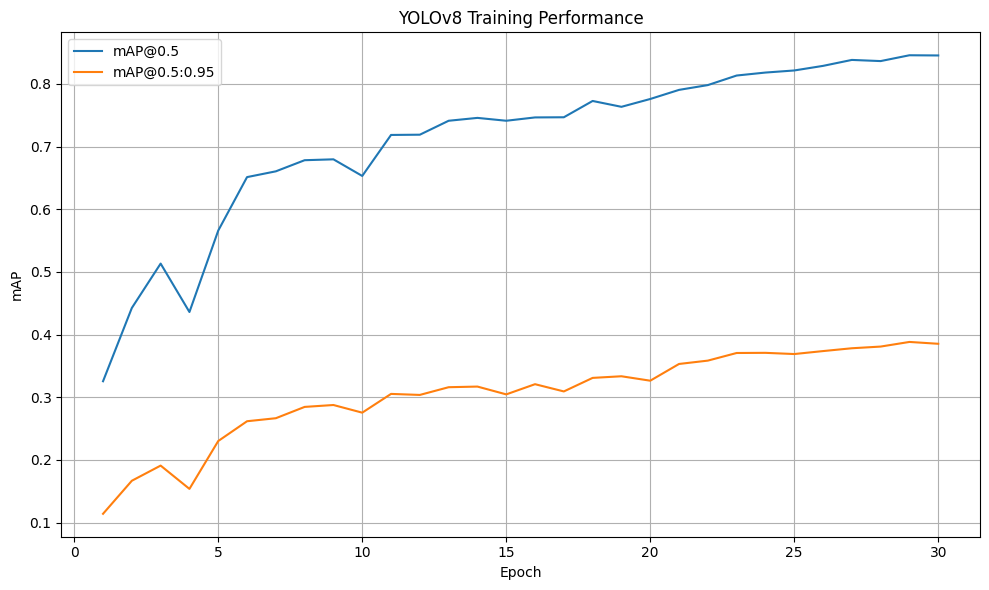

In [42]:
# Load your training results CSV
df = pd.read_csv('runs/detect/train/results.csv')

# Plot mAP metrics
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')

plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('YOLOv8 Training Performance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
model = YOLO('runs/detect/train/weights/best.pt')
metrics = model.val(data='data.yaml', imgsz=416, batch=16)

Ultralytics 8.3.136  Python-3.9.21 torch-2.7.0+cpu CPU (AMD Ryzen 5 5600 6-Core Processor)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 119.739.4 MB/s, size: 17.1 KB)


val: Scanning C:\Users\Zaky\Documents\p2-final-project-ftds-hck-026\valid\labels.cache... 1766 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1766/1766 [00:00<?, ?it/s]
c:\Users\Zaky\anaconda3\envs\tensorflow\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:42<00:00,  2.59it/s]


                   all       1766       1766      0.852      0.781      0.846      0.389
                     0        391        391      0.967      0.971      0.977      0.528
                     1        389        389      0.826      0.846      0.901      0.399
                     2        225        225      0.776      0.476      0.622      0.223
                     3        366        366      0.797       0.72        0.8      0.384
                     4        395        395      0.895      0.891      0.928      0.409
Speed: 0.5ms preprocess, 21.0ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\val


In [8]:
model = YOLO('yolov8n.pt')
model.train(data='data.yaml', epochs=20, imgsz=416, batch=16, patience=5)

New https://pypi.org/project/ultralytics/8.3.138 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.136  Python-3.9.21 torch-2.7.0+cpu CPU (AMD Ryzen 5 5600 6-Core Processor)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer

train: Scanning C:\Users\Zaky\Documents\p2-final-project-ftds-hck-026\train\labels.cache... 6181 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6181/6181 [00:00<?, ?it/s]

val: Fast image access  (ping: 0.20.0 ms, read: 4.21.4 MB/s, size: 19.3 KB)



c:\Users\Zaky\anaconda3\envs\tensorflow\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\Zaky\Documents\p2-final-project-ftds-hck-026\valid\labels.cache... 1766 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1766/1766 [00:00<?, ?it/s]

Plotting labels to runs\detect\train2\labels.jpg... 



c:\Users\Zaky\anaconda3\envs\tensorflow\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs\detect\train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      2.374      3.615      1.535         11        416: 100%|██████████| 387/387 [07:51<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [01:00<00:00,  1.09s/it]


                   all       1766       1766      0.484      0.369      0.326      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      2.141       2.47      1.434          4        416: 100%|██████████| 387/387 [07:15<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:51<00:00,  1.09it/s]


                   all       1766       1766      0.379      0.469      0.443      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      2.106      2.124       1.43          9        416: 100%|██████████| 387/387 [07:13<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:51<00:00,  1.09it/s]

                   all       1766       1766      0.481      0.485      0.472      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G       2.07      1.963      1.423         10        416: 100%|██████████| 387/387 [07:51<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:56<00:00,  1.02s/it]


                   all       1766       1766      0.641      0.486      0.498      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      2.033      1.846      1.388          8        416: 100%|██████████| 387/387 [07:41<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:53<00:00,  1.04it/s]

                   all       1766       1766      0.531      0.507      0.512      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      2.006      1.749      1.372          8        416: 100%|██████████| 387/387 [07:31<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:51<00:00,  1.09it/s]

                   all       1766       1766      0.658      0.563      0.603      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      1.983      1.702      1.357          6        416: 100%|██████████| 387/387 [07:16<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:51<00:00,  1.09it/s]

                   all       1766       1766      0.673      0.579      0.654      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      1.964      1.648       1.35          8        416: 100%|██████████| 387/387 [07:16<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:51<00:00,  1.08it/s]

                   all       1766       1766      0.719      0.575      0.675       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      1.943      1.594      1.346          4        416: 100%|██████████| 387/387 [07:15<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:51<00:00,  1.09it/s]

                   all       1766       1766      0.761      0.602      0.693      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      1.922      1.538      1.332          4        416: 100%|██████████| 387/387 [07:16<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:51<00:00,  1.09it/s]

                   all       1766       1766       0.79      0.616      0.718      0.304


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


c:\Users\Zaky\anaconda3\envs\tensorflow\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
      11/20         0G      1.868      1.393      1.422          5        416: 100%|██████████| 387/387 [07:11<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:51<00:00,  1.08it/s]

                   all       1766       1766      0.762      0.629      0.724      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      1.864      1.323      1.415          5        416: 100%|██████████| 387/387 [07:09<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:51<00:00,  1.08it/s]

                   all       1766       1766      0.761      0.669      0.749      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      1.845      1.277      1.396          5        416: 100%|██████████| 387/387 [07:09<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:51<00:00,  1.08it/s]

                   all       1766       1766      0.763      0.699       0.75      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G      1.833      1.255      1.392          5        416: 100%|██████████| 387/387 [07:08<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:51<00:00,  1.08it/s]

                   all       1766       1766      0.787      0.715      0.776      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G      1.824      1.231      1.385          5        416: 100%|██████████| 387/387 [07:09<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:51<00:00,  1.09it/s]

                   all       1766       1766      0.795      0.722      0.804      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G      1.809      1.183      1.373          5        416: 100%|██████████| 387/387 [07:08<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:51<00:00,  1.08it/s]

                   all       1766       1766      0.803      0.728      0.808      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G      1.788      1.159      1.362          5        416: 100%|██████████| 387/387 [07:09<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:51<00:00,  1.08it/s]

                   all       1766       1766       0.83      0.752      0.818      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G      1.779      1.135      1.353          5        416: 100%|██████████| 387/387 [07:10<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:51<00:00,  1.08it/s]

                   all       1766       1766      0.819      0.754      0.819      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G      1.767       1.12      1.344          5        416: 100%|██████████| 387/387 [07:10<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:52<00:00,  1.07it/s]

                   all       1766       1766      0.836      0.736       0.82      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/20         0G      1.748      1.083      1.339          5        416: 100%|██████████| 387/387 [07:12<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:53<00:00,  1.06it/s]

                   all       1766       1766      0.828      0.763      0.821      0.369



20 epochs completed in 2.730 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 6.2MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.136  Python-3.9.21 torch-2.7.0+cpu CPU (AMD Ryzen 5 5600 6-Core Processor)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:45<00:00,  1.24it/s]


                   all       1766       1766      0.827      0.763      0.821      0.368
                     0        391        391      0.938      0.972      0.968      0.502
                     1        389        389      0.826      0.843      0.886      0.378
                     2        225        225       0.72      0.422       0.56      0.199
                     3        366        366      0.811      0.702      0.788      0.376
                     4        395        395      0.842      0.876      0.901      0.386
Speed: 0.6ms preprocess, 22.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000021B8A97CF70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
    

In [9]:
model = YOLO('runs/detect/train2/weights/best.pt')
metrics = model.val(data='data.yaml', imgsz=416, batch=16)

Ultralytics 8.3.136  Python-3.9.21 torch-2.7.0+cpu CPU (AMD Ryzen 5 5600 6-Core Processor)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 216.165.6 MB/s, size: 19.3 KB)


val: Scanning C:\Users\Zaky\Documents\p2-final-project-ftds-hck-026\valid\labels.cache... 1766 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1766/1766 [00:00<?, ?it/s]
c:\Users\Zaky\anaconda3\envs\tensorflow\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:40<00:00,  2.74it/s]


                   all       1766       1766      0.827      0.763      0.821      0.368
                     0        391        391      0.938      0.972      0.968      0.502
                     1        389        389      0.826      0.843      0.886      0.378
                     2        225        225       0.72      0.422       0.56      0.199
                     3        366        366      0.811      0.702      0.788      0.376
                     4        395        395      0.842      0.876      0.901      0.386
Speed: 0.5ms preprocess, 20.0ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\val2
